## Data analytics assignment w/ Pandas and Socrata API

<p>
Point of the assingment is to demonstrate a technique or process from our course and apply it to some publicly available data set. While not a requirement for the assignment, we will also use this opportunity to utilize an API to retrieve the data which we will then filter and format into a useable form. (*We definitely aren't doing this extra work so I can have a reference document for the future. No way, that would be silly.*)

In order to access data via the SODA API we import the Socrata module. The imported configs holds our app token so that it won't be publicly available when uploaded to github. You can learn how to generate your own app token [here](https://support.socrata.com/hc/en-us/articles/360015776014-API-Keys), for free. 
</p>

In [21]:
import configs as cfg
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
from sodapy import Socrata

To access our data, we need identifiers for our endpoint. Our domain is data.seattle.gov and the specific dataset we are pulling from, [Code Complaints and Violations](https://data.seattle.gov/Community/Code-Complaints-and-Violations/ez4a-iug7) is identified by ez4a-iug7.

Using our token we build our client to query

In [3]:

data_url ="data.seattle.gov"
data_set="ez4a-iug7"

app_token = cfg.atoken
client=Socrata(data_url,app_token)
#client.timeout = 60


Unfortunately, the dataset we are looking at is quite big and we can only query for 50,000 rows are less per query. First, we'll check for the size of our dataset and from there we will download in pieces using offset.

In [5]:
count = client.get(data_set, select="COUNT(*)")
print(count)

[{'COUNT': '172149'}]


With over 170,000 records we need to request multiple times, which we can do via offsets to increment through the database.

In [6]:
start = 0
block = 5000
results = []
while start < int(count[0]['COUNT']):
    results.extend(client.get(data_set, offset=start, limit=block))
    start +=block
    
df = pd.DataFrame.from_records(results)

df.to_csv("complaintsdata.csv")


In [3]:
df=pd.read_csv("complaintsdata.csv")

## The dataset

<p>The dataset we've just pulled is a database of complaints filed the Seattle Depatment of Construction & Inspections. The data is really interesting because it contains all complaints filed by phone, online, and via the more recent "Find it, Fix it" app. Complaints can be varied from vendors using land improperly to elevators not working in buildings or potholes needing to be fixed. The data isn't curated into precise categories, as the categories may be user selected and thus not the most trustworthy, but that is dependent on the vagueness of reports. 

Besides inaccuracy due to the variety of user input, there are a few more caveats to using the database
* The dataset holds records from as far back as 2003, but the "Find it, Fix it" app wasn't released until 2013, which can skew any statistical outcomes if we look at data over time. Unfortunately we don't have any user statistics or complaint demographics so there doesn't seem to be any nice way to normalize
* The category of complaint isn't required to be set when making your submission, meaning if we try to find records pertaining to vegetation, we may have to filter records not only by the "Weeds" category, but also by descriptions that contain vegetation related words.
* The dataset is indexed on each complaint, so we need to count the dataset if we want to analyze by individual dates.
</p>

### Goal

<p>
We have a massive dataset with lots of stuff we don't care about. For the purposes of this project, we want to transform the dataset into the following:

* only reports that occur in a single calendar year, Jan 1 2021 to Dec 31 2021
* only reports of weeds, vegetation, or moss
* per day complaint counts for each day to look at trends
</p>






Now, we have just downloaded a massive amount of data, to the tune of an ~87 mb .CSV file. So, lets focus on filtering some of that info down, starting with their dates.

In [4]:
print(df.columns.tolist())
print(len(df.index))

['Unnamed: 0', 'recordnum', 'recordtype', 'recordtypemapped', 'recordtypedesc', 'description', 'opendate', 'inspectiondate', 'lastinspresult', 'statuscurrent', 'originaladdress1', 'originalcity', 'originalstate', 'originalzip', 'link', 'latitude', 'longitude', 'location1']
172149


In [150]:
y20 = df[(df['opendate'] >= '2020-01-01') & (df['opendate'] < '2021-01-01')]
y20.shape

(12419, 18)

In [151]:
y20Complaint = y20[y20['recordtype'] =='Complaint']
y20Complaint.shape
y20Complaint.head()

,Unnamed: 0,recordnum,recordtype,recordtypemapped,recordtypedesc,description,opendate,inspectiondate,lastinspresult,statuscurrent,originaladdress1,originalcity,originalstate,originalzip,link,latitude,longitude,location1
142748,142748,000101-20CP,Complaint,Request,Land Use,Continue to allow trash to build up on deck an...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.2906583...",Completed,Completed,1403 33RD AVE,SEATTLE,WA,98122.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.613063,-122.290658,"{'latitude': '47.61306347', 'longitude': '-122..."
142749,142749,000102-20CP,Complaint,Request,NaN,I need to turn the heat up to 80 to warm the a...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3231740...",NaN,Completed,520 TERRY AVE,SEATTLE,WA,98104.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.606010,-122.323174,"{'latitude': '47.60601001', 'longitude': '-122..."
142750,142750,000103-20CP,Complaint,Request,Construction,Houses under construction have a Porta Potty p...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3112108...",NaN,Completed,1605 E MARION ST,SEATTLE,WA,98122.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.610543,-122.311211,"{'latitude': '47.6105427', 'longitude': '-122...."
142751,142751,000104-20CP,Complaint,Request,NaN,I live in a rental in the basement of this hom...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.3337614...",NaN,Closed,11328 Meridian AVE N,NaN,NaN,NaN,{'url': 'https://cosaccela.seattle.gov/portal/...,47.711339,-122.333761,"{'latitude': '47.71133856', 'longitude': '-122..."
142752,142752,000105-20CP,Complaint,Request,Noise,There has been a piece of machinery running fo...,2020-01-01,"{'type': 'Point', 'coordinates': [-122.362525,...",Completed,Completed,342 NW 89TH ST,SEATTLE,WA,98117.0,{'url': 'https://cosaccela.seattle.gov/portal/...,47.693700,-122.362525,"{'latitude': '47.69369983', 'longitude': '-122..."


We need to create two masks, one for the "Weeds" type complaint, and one for 

In [152]:
keywords = ['weeds', 'vegetation', 'moss', 'overgrown', 'overgrowth', 'vines']
regstring = '|'.join(keywords)
keymask = y20Complaint['description'].str.contains(regstring, case = False, na=False) #remove case sensitivity and set all empty cells to false
#print(keymask)
print(keymask.value_counts())
typedescmask = y20Complaint['recordtypedesc']=='Weeds'
print(typedescmask.value_counts())
#print(typedescmask)
fy20 = y20Complaint[keymask | typedescmask] #selects only rows if either mask has a True
fy20.shape
#fy21.head()

False    9431
True     1200
Name: description, dtype: int64
False    8986
True     1645
Name: recordtypedesc, dtype: int64


(1850, 18)

In [153]:
fy20['description'].head()
fy20.iloc[3,5]

print(fy20.loc[fy20['opendate']=='2021-12-8'])

Empty DataFrame
Columns: [Unnamed: 0, recordnum, recordtype, recordtypemapped, recordtypedesc, description, opendate, inspectiondate, lastinspresult, statuscurrent, originaladdress1, originalcity, originalstate, originalzip, link, latitude, longitude, location1]
Index: []


In [154]:
fy20.to_csv("vegcomplaints.csv")

Make a container for each day in the year

In [22]:
fy20 = pd.read_csv("vegcomplaints.csv")

dates = pd.date_range(start='2020-01-01', end='2020-12-31').strftime('%Y-%m-%d')
days = np.arange(0,366)
vegCounts = pd.DataFrame(data = dates,columns = ['dates'])
print(vegCounts.iloc[0,0])
counts = []
print(fy20.opendate.value_counts())
print(len(fy20[fy20["opendate"] == "2021-01-02"]))
for x in days:
    counts.append(len(fy20[fy20["opendate"] == vegCounts.iloc[x,0]]))
print(counts)
vegCounts['counts'] = counts



2020-01-01
2020-08-14    31
2020-06-05    27
2020-07-08    23
2020-06-03    21
2020-06-11    21
              ..
2020-10-07     1
2020-10-11     1
2020-10-10     1
2020-10-02     1
2020-12-31     1
Name: opendate, Length: 334, dtype: int64
0
[1, 2, 3, 0, 0, 4, 2, 4, 10, 3, 1, 2, 3, 4, 1, 5, 7, 0, 0, 1, 4, 1, 4, 6, 1, 0, 9, 5, 3, 3, 3, 2, 0, 2, 0, 7, 3, 8, 0, 1, 8, 7, 2, 9, 3, 2, 2, 2, 6, 11, 8, 8, 2, 1, 2, 3, 6, 7, 4, 0, 5, 3, 4, 3, 5, 3, 3, 1, 4, 6, 2, 18, 1, 3, 8, 2, 4, 2, 1, 1, 0, 0, 3, 3, 1, 4, 7, 1, 0, 1, 2, 1, 0, 4, 1, 0, 1, 4, 3, 2, 4, 4, 4, 7, 2, 2, 4, 2, 7, 2, 4, 7, 3, 5, 12, 2, 1, 1, 4, 6, 6, 14, 3, 1, 11, 4, 7, 6, 6, 2, 3, 5, 11, 9, 12, 7, 3, 6, 8, 9, 13, 7, 17, 9, 9, 6, 9, 5, 15, 12, 1, 13, 15, 10, 21, 8, 27, 8, 4, 7, 8, 11, 21, 5, 11, 7, 11, 5, 7, 7, 4, 4, 6, 12, 10, 6, 13, 13, 6, 4, 19, 16, 4, 3, 5, 1, 2, 2, 12, 23, 15, 6, 9, 9, 6, 14, 4, 10, 12, 0, 1, 5, 5, 9, 8, 9, 0, 3, 9, 8, 9, 11, 2, 3, 2, 9, 9, 3, 7, 7, 4, 5, 17, 12, 9, 10, 31, 4, 4, 15, 7, 8, 10, 5, 3, 6, 5, 4, 8, 

We now want to grab 5 things:
* overall average in the year
* average and std for winter ( time from 1/1 to start of spring 3/19 and then start of winter 12/21 to 12/31)
* avg and std for summer (time from start of summer 6/20 to start of fall 9/22)

In [23]:
yearAvg = vegCounts["counts"].mean()

winterC = vegCounts[
    ((vegCounts['dates'] >= "2020-01-01") & (vegCounts['dates'] < "2020-03-19"))
    |
    ((vegCounts['dates'] >= "2020-12-21") & (vegCounts['dates'] < "2020-12-31"))]

summerC = vegCounts[
    (vegCounts['dates'] >= "2020-06-20") & (vegCounts['dates'] < "2020-09-22")]
wN = len(winterC)
sN = len(summerC)
wAvg = winterC["counts"].mean()
wSTD = winterC["counts"].std()
sAvg = summerC["counts"].mean()
sSTD = summerC["counts"].std()
print(yearAvg, wAvg, wSTD, sAvg, sSTD)

5.054644808743169 3.4545454545454546 3.0958225130638377 7.340425531914893 5.167210914427612


Stats goal:
left-tailed hypothesis test for two population means

We hypothesize that, in general, people are more likely to file complaints for vegetation-based issues in winter than during the summer. We have two samples, one being the amount of complaints in winter 2020 and the other in summer 2020. We do not know information outside of 2020, only the subset of 2020. So, we will approach the problem as a two-sample unpaired t-test, with a significance level of 0.05. Unpaired because while they are both subsets of 2020, we are testing for summer and winter in general which are distinct periods.

So, we form the following null and alternate hypotheses:
$$
H_{0}: \mu _{w} = \mu _{s} \\ 
H_{a}: \mu _{w} < \mu _{s}
$$

And find the following t-statistic
$$
t=\frac{\overline{x_{w}}-\overline{x_{s}}}{\sqrt{\frac{s_{w}^{2}}{n_{w}}+\frac{s_{s}^{2}}{n_{s}}}}
$$

with 
$$
df=n_{w} + n_{s}-2
$$

where $\overline{x_{i}}$, $s_{i}$, and $n_{i}$ are the mean, standard deviation, and sample size of the samples, respectively.

In [24]:
tstat = (wAvg - sAvg)/((wSTD**2 / wN) + (sSTD**2 / sN))**(0.5)
df = wN + sN - 2

-6.198958089732714 180


With $t \approx -6.198958$ and $df = 180$ we can plot the t-distribution and find our p-value.

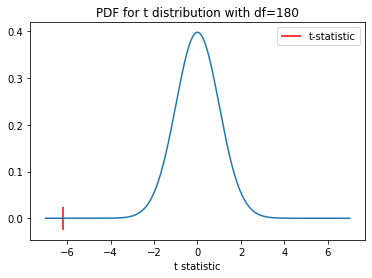

2.4963214721085264e-09


In [32]:
import matplotlib.pyplot as plt

results = st.ttest_ind(winterC["counts"], summerC["counts"], equal_var=False, alternative='less')

t_dist = st.t(180)
t_x = np.linspace(-7,7,1000)
pdf_vals = t_dist.pdf(t_x)
plt.vlines(tstat, -0.025, 0.025, color = 'r', label='t-statistic')
plt.fill_between(t_x, pdf_vals,0, where= t_x<=tstat, color='r')
plt.plot(t_x, pdf_vals)
#plt.plot(tstat, results.pvalue, marker="x", markersize=20)
plt.xlabel('t statistic')
plt.title('PDF for t distribution with df=180')
plt.legend()
plt.show()

print(results.pvalue)


Maybe unsurprisingly, we found that our null hypothesis was immensely wrong. We had allowed ourselves a significance of $0.05$ to reject our result and we found $p\approx2.5e$-$9$. We can say with confidence that Seattle complainers will, in general, be more likely to report their complaints with vegetation in the summer than in the winter.